# **Import Library**

Mengimpor semua libraries yang akan digunakan

In [2]:
# Libraries yang sering digunakan
import os, shutil
import zipfile
import random
import pathlib
import numpy as np
import pandas as pd
from shutil import copyfile
from google.colab import files
from random import sample
from pathlib import Path

In [ ]:
# Libraries untuk pemrosesan data gambar
import cv2
import skimage
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from skimage import io
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from PIL import Image
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
# Libraries untuk pembangunan model
!pip install tensorflowjs
import tensorflow as tf
import keras
import tensorflowjs as tfjs
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Input, InputLayer, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import TFSMLayer
from keras import Input, Model
from tqdm import tqdm as tq
from tqdm.notebook import tqdm as tq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
!pip show tensorflowjs

Name: tensorflowjs
Version: 4.22.0
Summary: 
Home-page: https://js.tensorflow.org/
Author: Google LLC
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: flax, importlib_resources, jax, jaxlib, packaging, six, tensorflow, tensorflow-decision-forests, tensorflow-hub, tf-keras
Required-by: 


# **Load Data**

Memuat dataset yang akan digunakan dari website Kaggle

In [3]:
upload = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sumn2u/garbage-classification-v2
!unzip garbage-classification-v2.zip -d garbage-classification-v2

Streaming output truncated to the last 5000 lines.
  inflating: garbage-classification-v2/garbage-dataset/paper/paper_847.jpg  
  inflating: garbage-classification-v2/garbage-dataset/paper/paper_848.jpg  
  inflating: garbage-classification-v2/garbage-dataset/paper/paper_849.jpg  
  inflating: garbage-classification-v2/garbage-dataset/paper/paper_851.jpg  
  inflating: garbage-classification-v2/garbage-dataset/paper/paper_852.jpg  
  inflating: garbage-classification-v2/garbage-dataset/paper/paper_853.jpg  
  inflating: garbage-classification-v2/garbage-dataset/paper/paper_855.jpg  
  inflating: garbage-classification-v2/garbage-dataset/paper/paper_856.jpg  
  inflating: garbage-classification-v2/garbage-dataset/paper/paper_857.jpg  
  inflating: garbage-classification-v2/garbage-dataset/paper/paper_859.jpg  
  inflating: garbage-classification-v2/garbage-dataset/paper/paper_861.jpg  
  inflating: garbage-classification-v2/garbage-dataset/paper/paper_863.jpg  
  inflating: garbage-clas

# **Data Preparation**

Melakukan tahap persiapan data agar bisa digunakan untuk modeling

In [ ]:
# Path asal dataset
awal_data = "garbage-classification-v2/garbage-dataset"
data_dir = "garbage/dataset"
extract_to = "trash_manual"   # Folder hasil ekstraksi dari zip
zip_path = "data_fix.zip"

# Buat direktori baru untuk dataset gabungan
os.makedirs(data_dir, exist_ok=True)

# === 1. Salin file dan folder dari direktori asal ===
for category in os.listdir(awal_data):
    category_dir = os.path.join(awal_data, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(data_dir, category), dirs_exist_ok=True)

# === 2. Ekstrak data.zip ke direktori trash_manual ===
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# === 3. Pindahkan isi folder 'data' ke trash_manual langsung ===
manual_data = os.path.join(extract_to, "data_fix")
if os.path.exists(manual_data):
    for category in os.listdir(manual_data):
        shutil.move(os.path.join(manual_data, category), extract_to)

# Hapus folder "data" setelah isinya dipindahkan
shutil.rmtree(manual_data)

# === 4. Salin hasil ekstrak ke dataset utama ===
for category in os.listdir(extract_to):
    category_dir = os.path.join(extract_to, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(data_dir, category), dirs_exist_ok=True)

# === 5. Hapus folder "trash" di direktori utama ===
trash_dir = os.path.join(data_dir, "trash")
if os.path.exists(trash_dir):
    shutil.rmtree(trash_dir)

# === 6. Gabung label dalam kurung "trash" ke label utama ===
def bersihin_label(label):
    if "(trash)" in label:
        label = label.replace(" (trash)", "").replace("(trash)", "").strip()
    return label

# === 7. Proses penggabungan otomatis ===
for category in os.listdir(data_dir):
    clean_name = bersihin_label(category)
    old_path = os.path.join(data_dir, category)
    new_path = os.path.join(data_dir, clean_name)

    if clean_name != category:
        if os.path.exists(new_path):
            # Kalau folder utama sudah ada, pindahkan isinya
            for filename in os.listdir(old_path):
                shutil.move(os.path.join(old_path, filename), new_path)
            shutil.rmtree(old_path)
        else:
            os.rename(old_path, new_path)

# === 8. Hapus folder yang tidak relevan ===
for folder in os.listdir(data_dir):
    if folder.lower() in ['data', 'other', 'dataset', 'sample']:  # kamu bisa tambah di sini kalau ada yang aneh
        print(f"Menghapus folder tidak relevan: {folder}")
        shutil.rmtree(os.path.join(data_dir, folder))

# === 9. Hapus folder kosong (jika ada) ===
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path) and not os.listdir(folder_path):
        shutil.rmtree(folder_path)

In [ ]:
# Tampilkan hasil akhir
print("Label akhir yang terdeteksi otomatis:")
print(os.listdir(data_dir))

Label akhir yang terdeteksi otomatis:
['clothes', 'paper', 'plastic', 'battery', 'cardboard', 'shoes', 'biological', 'medical', 'glass', 'metal']


## Cek Dataset

Mengecek keadaan data

In [ ]:
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(data_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))
        file_name.append(name)

distribution_train = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

In [ ]:
distribution_train = distribution_train[distribution_train['labels'] != "trash"]

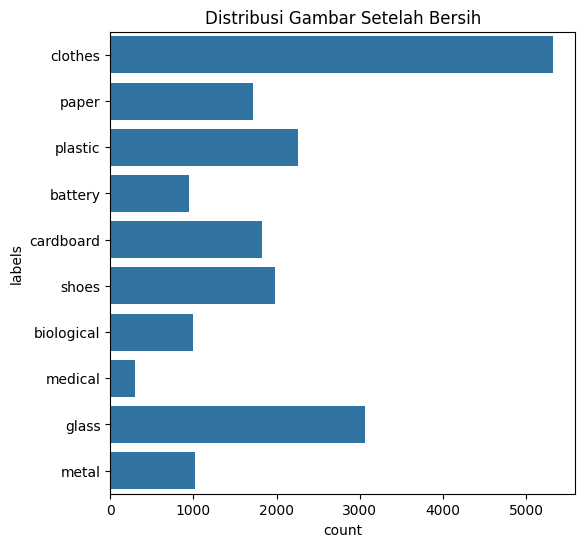

labels
clothes       5327
glass         3065
plastic       2258
shoes         1977
cardboard     1825
paper         1718
metal         1021
biological    1000
battery        944
medical        303
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(6, 6))
sns.countplot(y=distribution_train['labels'])
plt.title("Distribusi Gambar Setelah Bersih")
plt.show()

print(distribution_train['labels'].value_counts())

In [ ]:
# Cek label di level utama
print("Label utama di garbage/dataset:")
print(sorted(os.listdir("garbage/dataset")))

Label utama di garbage/dataset:
['battery', 'biological', 'cardboard', 'clothes', 'glass', 'medical', 'metal', 'paper', 'plastic', 'shoes']


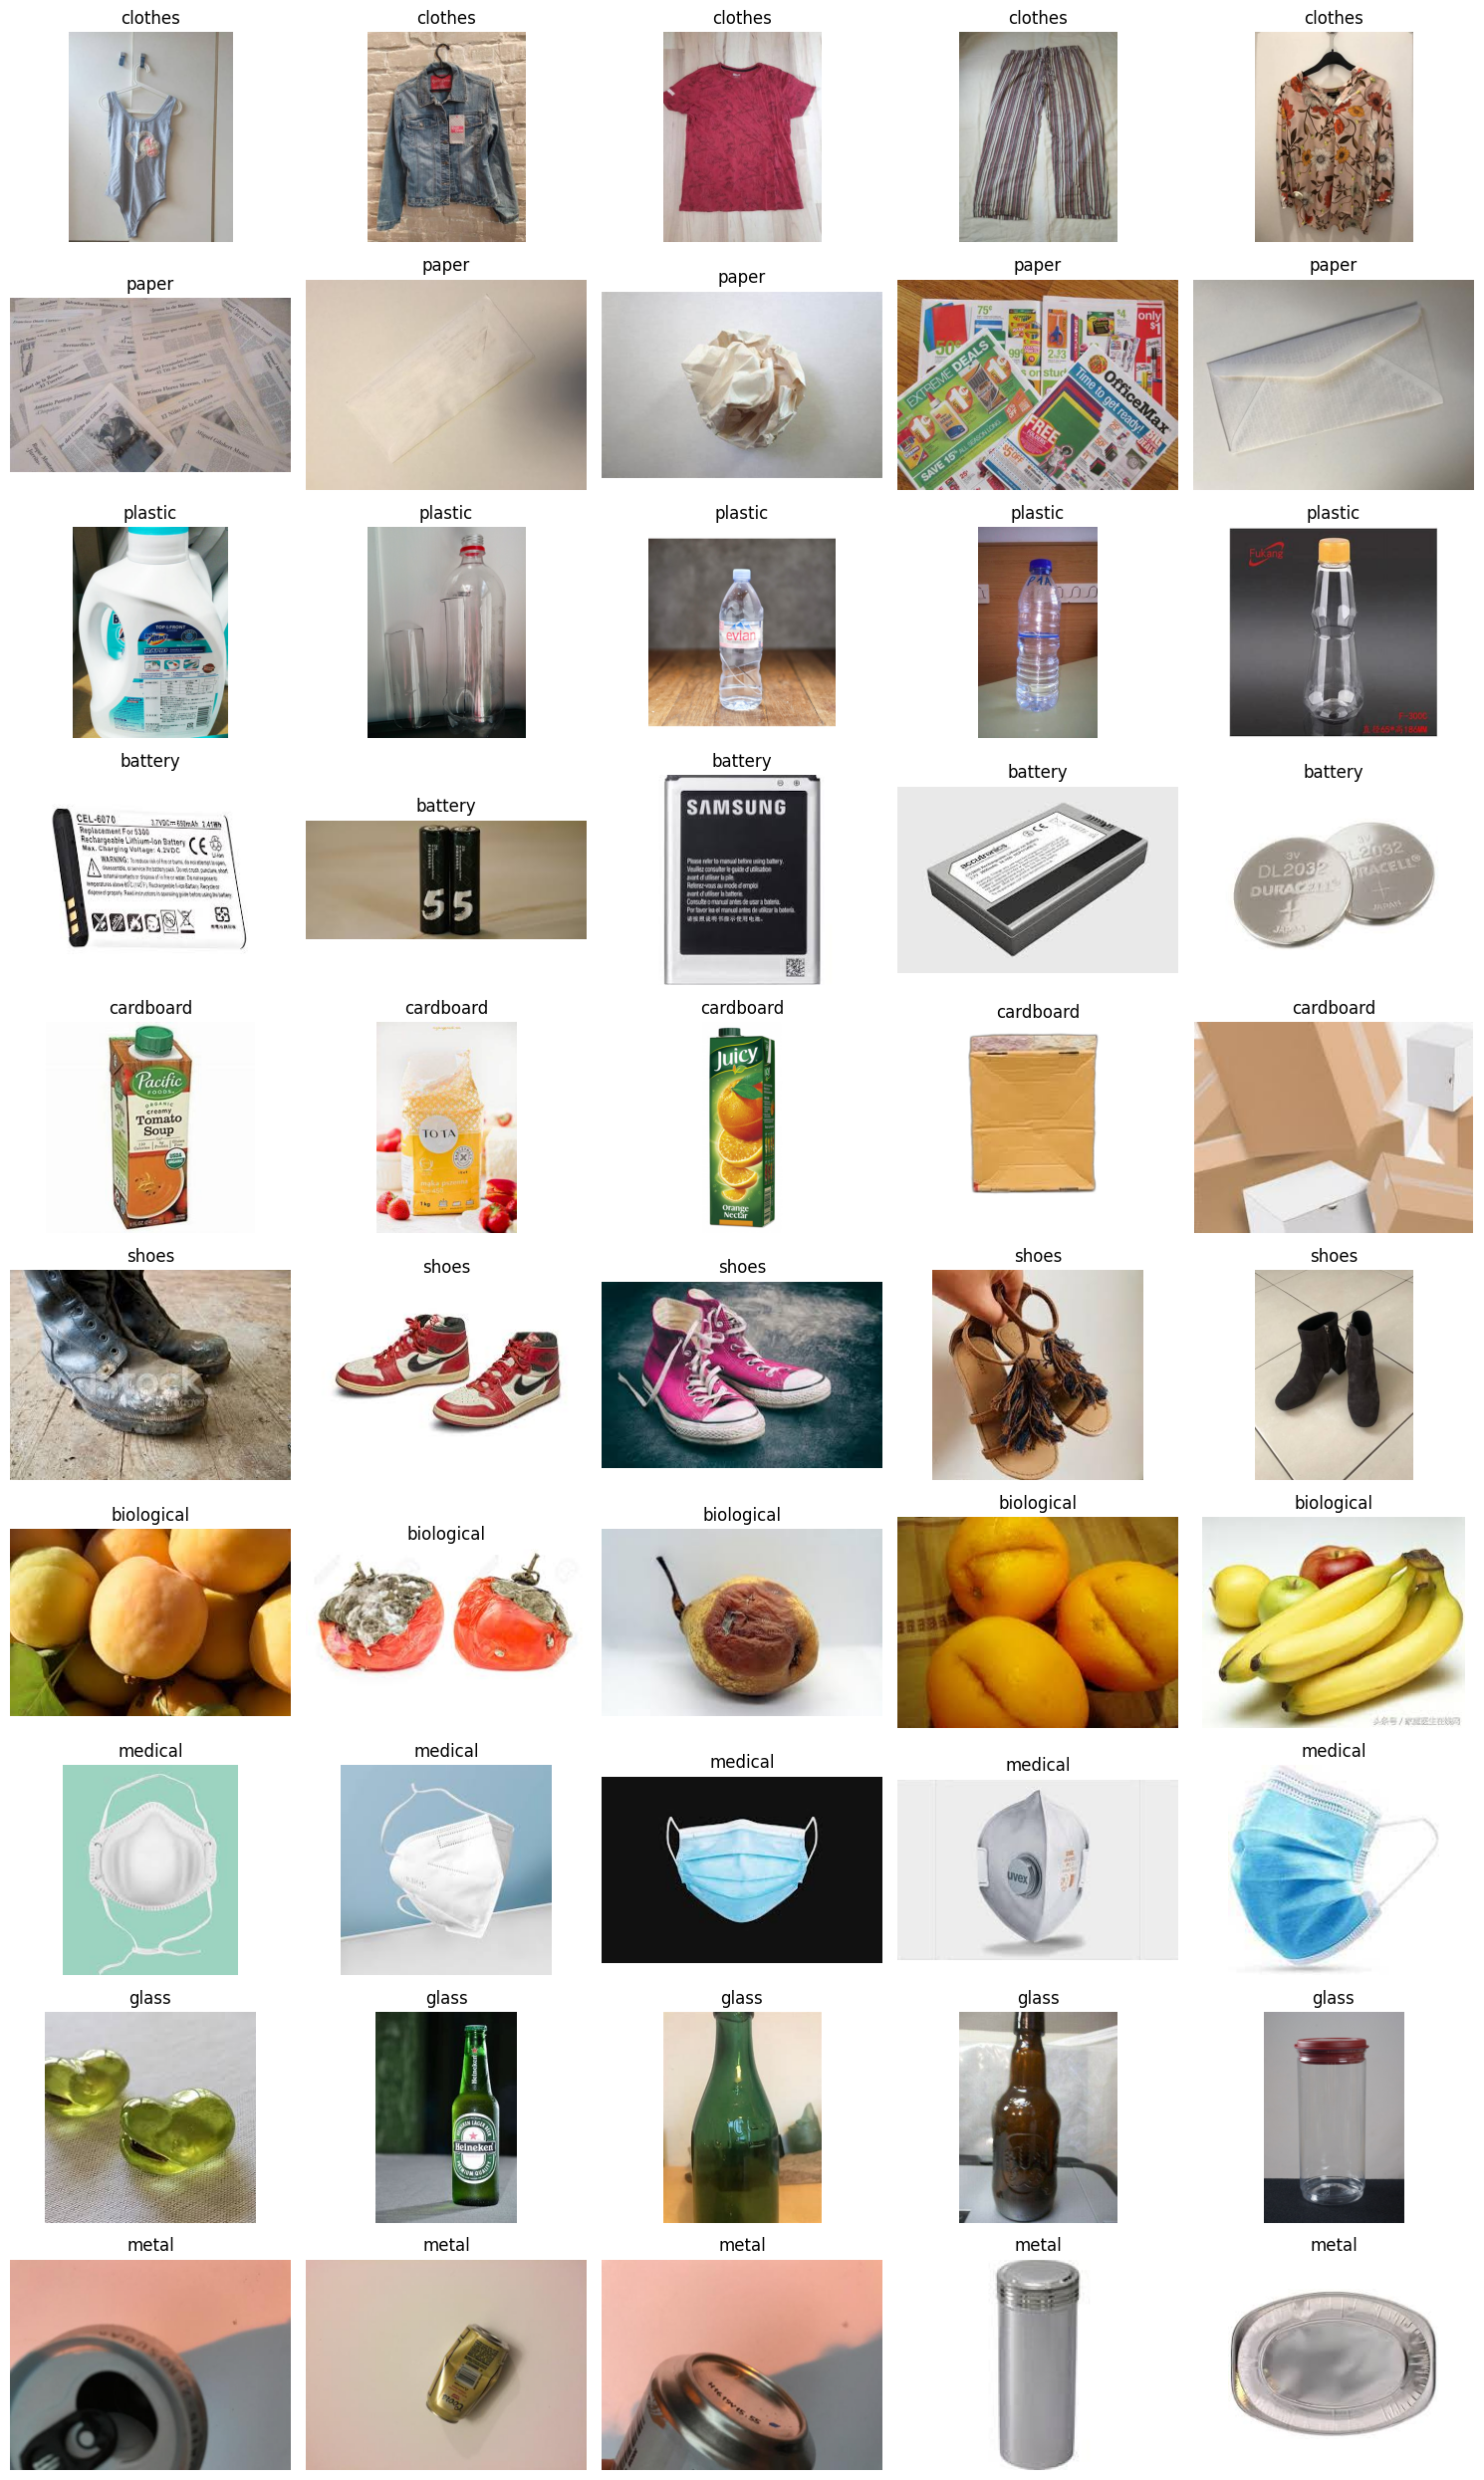

In [ ]:
# Ambil semua label unik dari dataframe
unique_labels = distribution_train['labels'].unique()

# Siapin figure (otomatis jumlah baris = jumlah label)
fig, axs = plt.subplots(len(unique_labels), 5, figsize=(15, len(unique_labels) * 2.5))

for i, label in enumerate(unique_labels):
    # Ambil semua path gambar sesuai label
    paths = distribution_train[distribution_train['labels'] == label]['path'].values

    # Kalo gambar kurang dari 5, ambil semua aja
    if len(paths) < 5:
        selected_paths = paths
    else:
        selected_paths = np.random.choice(paths, 5, replace=False)

    for j, img_path in enumerate(selected_paths):
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(label)
        axs[i, j].axis("off")

fig.tight_layout()
plt.show()


## **Split Data**

Membagi data menjadi trainset dan testset dengan rasio 80:20

In [ ]:
# Path dataset
garbage_path = "garbage/dataset/"
dataset_path = "Dataset-Final/"
TRAIN_DIR = os.path.join(dataset_path, "train")
TEST_DIR = os.path.join(dataset_path, "test")

# Loop folder buat list semua gambar + label
records = []
for path, subdirs, files in os.walk(garbage_path):
    if path == garbage_path:
        continue
    label_name = os.path.basename(path)
    for fname in files:
        records.append({
            "path": os.path.join(path, fname),
            "file_name": fname,
            "label": label_name
        })

df = pd.DataFrame(records)
print(f"Total gambar ditemukan: {len(df)}")

if df.empty:
    print("❌ Tidak ada data")
else:
    print("✅ Data berhasil diload")


Total gambar ditemukan: 19438
✅ Data berhasil diload


In [ ]:
X = df['path']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

df_train = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_test = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

df_all = pd.concat([df_train, df_test], ignore_index=True)
print("\nDistribusi Data Setelah Splitting:")
print(df_all.groupby(['set', 'labels']).size())


Distribusi Data Setelah Splitting:
set    labels    
test   battery        189
       biological     200
       cardboard      365
       clothes       1065
       glass          613
       medical         61
       metal          204
       paper          344
       plastic        452
       shoes          395
train  battery        755
       biological     800
       cardboard     1460
       clothes       4262
       glass         2452
       medical        242
       metal          817
       paper         1374
       plastic       1806
       shoes         1582
dtype: int64


In [ ]:
for index, row in tq(df_all.iterrows(), total=df_all.shape[0]):
    file_path = row['path']
    if not os.path.exists(file_path):
        print(f"⚠️ File tidak ditemukan: {file_path}")
        continue

    target_dir = os.path.join(dataset_path, row['set'], row['labels'])
    os.makedirs(target_dir, exist_ok=True)

    dest_path = os.path.join(target_dir, os.path.basename(file_path))
    if not os.path.exists(dest_path):
        shutil.copy2(file_path, dest_path)

  0%|          | 0/19438 [00:00<?, ?it/s]

In [ ]:
# Download /content/Dataset-Final/test sebagai zipfile

directory_to_zip = '/content/Dataset-Final/test'
zip_file_name = 'data_test.zip'

with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    for root, dirs, files_in_dir in os.walk(directory_to_zip):
        for file in files_in_dir:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(directory_to_zip, '..')))

files.download(zip_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **UnderSampling**

Melakukan tahap undersampling terhadap kelas mayoritas

In [ ]:
min_samples_per_class = 2000

class_counts = Counter(y_train)
print("\nDistribusi sebelum undersampling:")
print(class_counts)

sampling_strategy = {}
for cls, count in class_counts.items():
    if count > min_samples_per_class:
        sampling_strategy[cls] = min_samples_per_class
    else:
        sampling_strategy[cls] = count  # kelas kecil tidak diubah

print("\nSampling strategy:")
print(sampling_strategy)

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(
    X_train.values.reshape(-1, 1), y_train
)

# Konversi kembali jadi series
X_train_resampled = pd.Series(X_train_resampled.flatten())
y_train_resampled = pd.Series(y_train_resampled)

df_train_resampled = pd.DataFrame({
    'path': X_train_resampled,
    'labels': y_train_resampled,
    'set': 'train'
})

df_all = pd.concat([df_train_resampled, df_test], ignore_index=True)

print("\nDistribusi setelah undersampling:")
print(df_all.groupby(['set', 'labels']).size())


Distribusi sebelum undersampling:
Counter({'clothes': 4262, 'glass': 2452, 'plastic': 1806, 'shoes': 1582, 'cardboard': 1460, 'paper': 1374, 'metal': 817, 'biological': 800, 'battery': 755, 'medical': 242})

Sampling strategy:
{'clothes': 2000, 'cardboard': 1460, 'plastic': 1806, 'metal': 817, 'paper': 1374, 'shoes': 1582, 'battery': 755, 'glass': 2000, 'medical': 242, 'biological': 800}

Distribusi setelah undersampling:
set    labels    
test   battery        189
       biological     200
       cardboard      365
       clothes       1065
       glass          613
       medical         61
       metal          204
       paper          344
       plastic        452
       shoes          395
train  battery        755
       biological     800
       cardboard     1460
       clothes       2000
       glass         2000
       medical        242
       metal          817
       paper         1374
       plastic       1806
       shoes         1582
dtype: int64


## **Data Augmentation**

Melakukan augmentasi data untuk menghasilkan variasi data gambar

In [ ]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [ ]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness' : add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

In [ ]:
# Tentukan target augmentasi per kelas (jumlah gambar baru yang ingin ditambahkan)
target_counts = {
    'plastic': 200,
    'shoes': 400,
    'cardboard': 500,
    'paper': 650,
    'metal': 1200,
    'biological': 1200,
    'battery': 1250,
    'medical': 1750,
}

for cls, images_to_generate in target_counts.items():
    # Ambil gambar dari hasil undersampling untuk kelas ini
    image_files = df_train_resampled[df_train_resampled['labels'] == cls]['path'].tolist()

    if len(image_files) == 0:
        print(f"⚠️ Tidak ada gambar untuk kelas {cls} di data undersampled")
        continue

    augmented_path = os.path.join(dataset_path, "train", cls, "augmented")
    os.makedirs(augmented_path, exist_ok=True)

    print(f"Augmenting {cls}: +{images_to_generate} images")

    i = 1
    while i <= images_to_generate:
        img_path = random.choice(image_files)
        try:
            img = io.imread(img_path)

            # Terapkan 1 sampai beberapa transformasi acak
            for _ in range(random.randint(1, len(transformations))):
                img = random.choice(list(transformations.values()))(img)

            # Simpan gambar augmentasi
            cv2.imwrite(
                os.path.join(augmented_path, f"augmented_{i}.jpg"),
                img_as_ubyte(img)
            )
            i += 1
        except Exception as e:
            print(f"Skip {img_path} karena {e}")

print("\n✅ Augmentasi selesai.")

Streaming output truncated to the last 5000 lines.
Skip garbage/dataset/medical/trash_411.jpg karena OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)

Skip garbage/dataset/medical/trash_304.jpg karena OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArr

In [ ]:
augmented_records = []
for cls in target_counts.keys():
    augmented_path = os.path.join(dataset_path, "train", cls, "augmented")
    if os.path.exists(augmented_path):
        for fname in os.listdir(augmented_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                augmented_records.append({
                    'path': os.path.join(augmented_path, fname),
                    'labels': cls,
                    'set': 'train'
                })

df_augmented = pd.DataFrame(augmented_records)

# Gabungkan undersampled train + augmentasi + test set
df_train_final = pd.concat([df_train_resampled, df_augmented], ignore_index=True)
df_all_final = pd.concat([df_train_final, df_test], ignore_index=True)

print("\nDistribusi data setelah undersampling + augmentasi:")
print(df_all_final.groupby(['set', 'labels']).size())


Distribusi data setelah undersampling + augmentasi:
set    labels    
test   battery        189
       biological     200
       cardboard      365
       clothes       1065
       glass          613
       medical         61
       metal          204
       paper          344
       plastic        452
       shoes          395
train  battery       2005
       biological    2000
       cardboard     1960
       clothes       2000
       glass         2000
       medical       1992
       metal         2017
       paper         2024
       plastic       2006
       shoes         1982
dtype: int64



Distribusi data setelah undersampling + augmentasi:
set    labels    
test   battery        189
       biological     200
       cardboard      365
       clothes       1065
       glass          613
       medical         61
       metal          204
       paper          344
       plastic        452
       shoes          395
train  battery       2005
       biological    2000
       cardboard     1960
       clothes       2000
       glass         2000
       medical       1992
       metal         2017
       paper         2024
       plastic       2006
       shoes         1982
dtype: int64


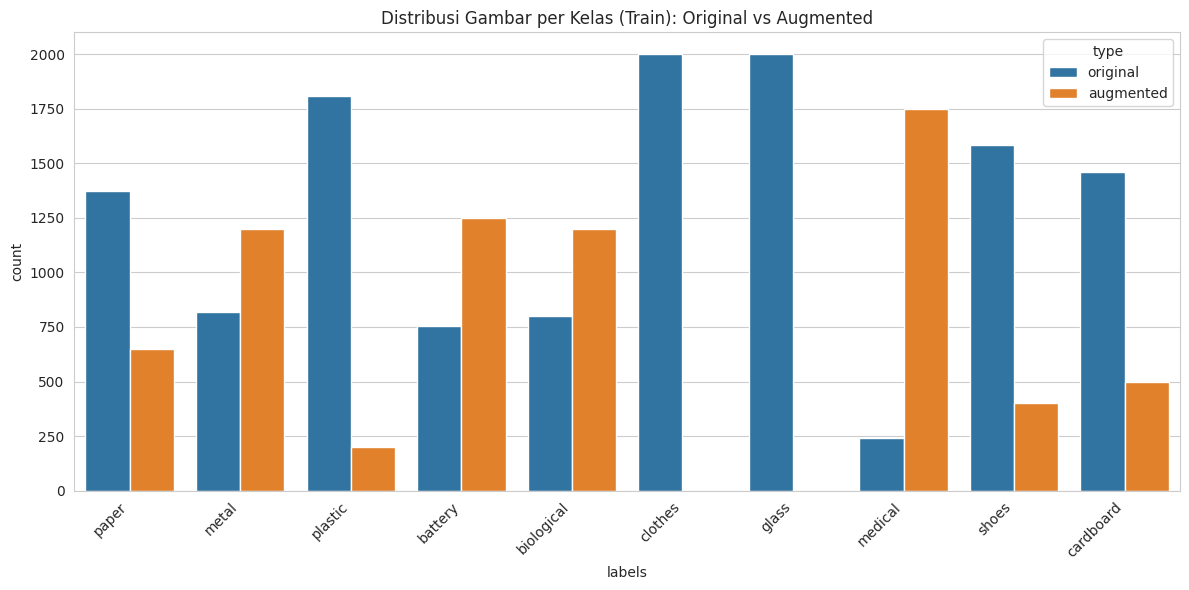


Ringkasan jumlah gambar per kelas setelah augmentasi dan undersampling:


type        augmented  original  total
labels                                
paper             650      1374   2024
metal            1200       817   2017
plastic           200      1806   2006
battery          1250       755   2005
biological       1200       800   2000
clothes             0      2000   2000
glass               0      2000   2000
medical          1750       242   1992
shoes             400      1582   1982
cardboard         500      1460   1960

In [ ]:
# --- Path Dataset Final ---
dataset_path = "Dataset-Final"

# --- Ambil Data Augmented ---
augmented_records = []
for cls in target_counts.keys():
    augmented_path = os.path.join(dataset_path, "train", cls, "augmented")
    if os.path.exists(augmented_path):
        for fname in os.listdir(augmented_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                augmented_records.append({
                    'path': os.path.join(augmented_path, fname),
                    'labels': cls,
                    'set': 'train',
                    'type': 'augmented'
                })

# DataFrame untuk augmented
df_augmented = pd.DataFrame(augmented_records)

# --- Gabungkan Data ---
# Gabungkan hasil undersampling, augmentasi, dan test set
df_train_final = pd.concat([df_train_resampled, df_augmented], ignore_index=True)
df_train_final['type'] = df_train_final['type'].fillna('original')  # Jika ada NaN di kolom "type"
df_all_final = pd.concat([df_train_final, df_test], ignore_index=True)

print("\nDistribusi data setelah undersampling + augmentasi:")
print(df_all_final.groupby(['set', 'labels']).size())

# --- Visualisasi distribusi final ---
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.countplot(
    data=df_all_final[df_all_final['set'] == 'train'],
    x="labels",
    hue="type",
    order=df_all_final[df_all_final['set'] == 'train']["labels"].value_counts().index
)
plt.title("Distribusi Gambar per Kelas (Train): Original vs Augmented")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- Tabel ringkas total per kelas ---
totals = df_all_final[df_all_final['set'] == 'train'].groupby(["labels", "type"]).size().unstack(fill_value=0)
totals["total"] = totals.sum(axis=1)

print("\nRingkasan jumlah gambar per kelas setelah augmentasi dan undersampling:")
display(totals.sort_values("total", ascending=False))

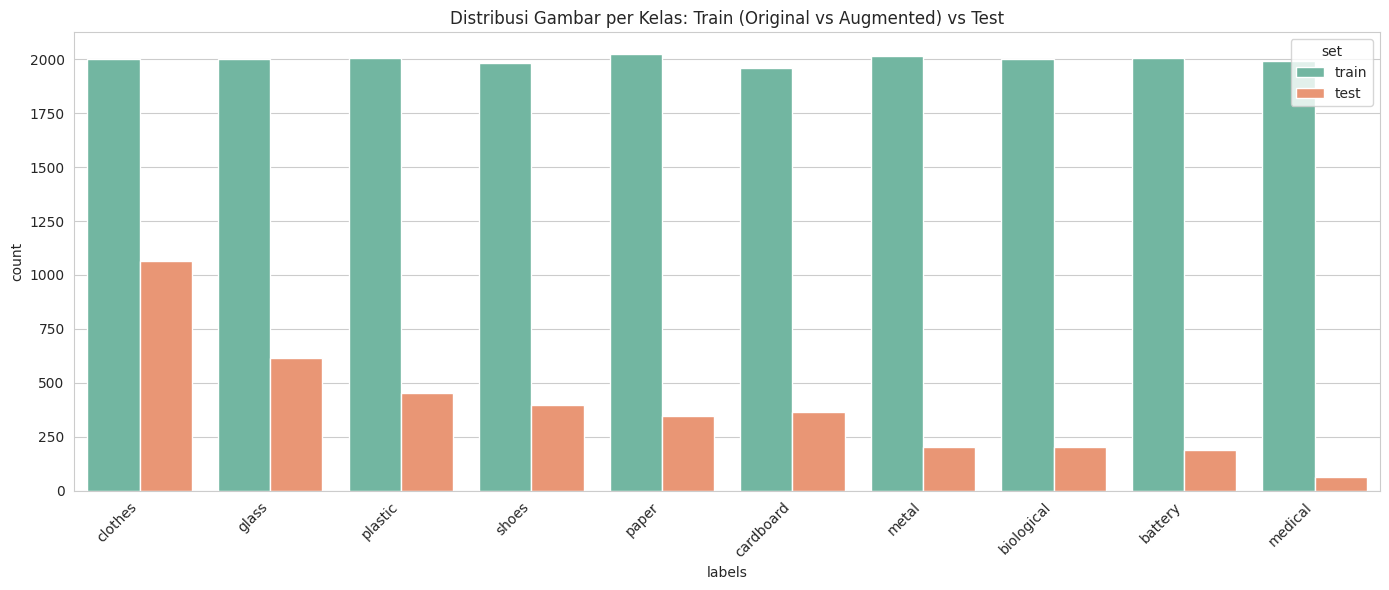

In [ ]:
# Buat kolom 'type' di df_all_final
df_all_final['type'] = df_all_final.apply(lambda x: 'augmented' if 'augmented' in x['path'] else 'original', axis=1)

# Visualisasi distribusi Original vs Augmented vs Test
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")
sns.countplot(
    data=df_all_final,
    x="labels",
    hue="set",
    order=df_all_final["labels"].value_counts().index,
    palette="Set2"
)
plt.title("Distribusi Gambar per Kelas: Train (Original vs Augmented) vs Test")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
# Path ke folder dataset augmented dan folder tujuan
augmented_dataset_path = "Dataset-Final/train"
final_dataset_path = "Dataset-Final"

# Looping untuk memindahkan gambar augmented ke folder tujuan
for cls in target_counts.keys():
    augmented_path = os.path.join(augmented_dataset_path, cls, "augmented")

    if os.path.exists(augmented_path):
        augmented_files = [
            os.path.join(augmented_path, f)
            for f in os.listdir(augmented_path)
            if f.lower().endswith(('jpg', 'jpeg', 'png'))
        ]

        print(f"Memindahkan {len(augmented_files)} gambar dari {augmented_path} ke folder tujuan...")

        for file_path in tqdm(augmented_files, desc=f"Memproses {cls}"):
            # Tentukan set (train) dan label
            set_type = "train"
            label_name = cls

            # Buat direktori tujuan di Dataset-Final sesuai set dan label
            target_directory = os.path.join(final_dataset_path, set_type, label_name)
            os.makedirs(target_directory, exist_ok=True)

            # Tentukan tujuan file (nama file untuk disalin)
            destination_file_name = os.path.basename(file_path)
            file_dest = os.path.join(target_directory, destination_file_name)

            # Salin file jika belum ada di tujuan
            if not os.path.exists(file_dest):
                shutil.copy2(file_path, file_dest)
            else:
                print(f"⚠️ File {destination_file_name} sudah ada di {file_dest}, skip salin.")

print("\n✅ Semua data augmented berhasil dipindahkan ke folder 'Dataset-Final/train'.")

Memindahkan 200 gambar dari Dataset-Final/train/plastic/augmented ke folder tujuan...


Memproses plastic: 100%|██████████| 200/200 [00:00<00:00, 6042.75it/s]


Memindahkan 400 gambar dari Dataset-Final/train/shoes/augmented ke folder tujuan...


Memproses shoes: 100%|██████████| 400/400 [00:00<00:00, 6516.08it/s]


Memindahkan 500 gambar dari Dataset-Final/train/cardboard/augmented ke folder tujuan...


Memproses cardboard: 100%|██████████| 500/500 [00:00<00:00, 6161.77it/s]


Memindahkan 650 gambar dari Dataset-Final/train/paper/augmented ke folder tujuan...


Memproses paper: 100%|██████████| 650/650 [00:00<00:00, 5486.20it/s]


Memindahkan 1200 gambar dari Dataset-Final/train/metal/augmented ke folder tujuan...


Memproses metal: 100%|██████████| 1200/1200 [00:00<00:00, 3620.51it/s]


Memindahkan 1200 gambar dari Dataset-Final/train/biological/augmented ke folder tujuan...


Memproses biological: 100%|██████████| 1200/1200 [00:00<00:00, 3211.62it/s]


Memindahkan 1250 gambar dari Dataset-Final/train/battery/augmented ke folder tujuan...


Memproses battery: 100%|██████████| 1250/1250 [00:00<00:00, 3141.92it/s]


Memindahkan 1750 gambar dari Dataset-Final/train/medical/augmented ke folder tujuan...


Memproses medical: 100%|██████████| 1750/1750 [00:00<00:00, 3498.18it/s]


✅ Semua data augmented berhasil dipindahkan ke folder 'Dataset-Final/train'.


## **Image Data Generator**

Melakukan pemrosesan data gambar menggunakan ImageDataGenerator, di dalamnya terdapat tahap normalisasi piksel gambar ke rentang [0, 1], serta membagi dataset menjadi data training, validasi, dan testing.

In [ ]:
# Definisikan direktori training dan test
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

# Ambil semua label (kelas) dari hasil final dataframe yang sudah digabungkan (train + test + augmented)
labels = df_all_final['labels'].unique()

# Looping untuk setiap label
for label in labels:
    # Direktori untuk setiap kelas di train dan test
    train_label_dir = os.path.join(TRAIN_DIR, label)
    test_label_dir = os.path.join(TEST_DIR, label)

    # Inisialisasi counter
    original_count = 0
    augmented_count = 0
    test_count = 0

    # === Langsung ambil dari DataFrame yang sudah disusun ===

    # Hitung jumlah original dan augmented di TRAIN berdasarkan DataFrame
    original_count = df_all_final[(df_all_final['labels'] == label) &
                                  (df_all_final['type'] == 'original') &
                                  (df_all_final['set'] == 'train')].shape[0]

    augmented_count = df_all_final[(df_all_final['labels'] == label) &
                                   (df_all_final['type'] == 'augmented') &
                                   (df_all_final['set'] == 'train')].shape[0]

    # Hitung jumlah di TEST
    test_count = df_all_final[(df_all_final['labels'] == label) &
                              (df_all_final['set'] == 'test')].shape[0]

    # Hasil
    print(f"\n=== {label.upper()} ===")
    print(f"🗂️  Total original images in training set: {original_count}")
    print(f"🗂️  Total augmented images in training set: {augmented_count}")
    print(f"🗂️  Total images in test set: {test_count}")
    print(f"📌 Total in train (original + augmented): {original_count + augmented_count}")


=== BATTERY ===
🗂️  Total original images in training set: 755
🗂️  Total augmented images in training set: 1250
🗂️  Total images in test set: 189
📌 Total in train (original + augmented): 2005

=== BIOLOGICAL ===
🗂️  Total original images in training set: 800
🗂️  Total augmented images in training set: 1200
🗂️  Total images in test set: 200
📌 Total in train (original + augmented): 2000

=== CARDBOARD ===
🗂️  Total original images in training set: 1460
🗂️  Total augmented images in training set: 500
🗂️  Total images in test set: 365
📌 Total in train (original + augmented): 1960

=== CLOTHES ===
🗂️  Total original images in training set: 2000
🗂️  Total augmented images in training set: 0
🗂️  Total images in test set: 1065
📌 Total in train (original + augmented): 2000

=== GLASS ===
🗂️  Total original images in training set: 2000
🗂️  Total augmented images in training set: 0
🗂️  Total images in test set: 613
📌 Total in train (original + augmented): 2000

=== MEDICAL ===
🗂️  Total original

In [ ]:
# Buat objek ImageDataGenerator yang menormalisasikan gambar
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255.)

# Generator untuk data latih dengan validasi subset
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Generator untuk data validasi
validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Generator untuk data uji
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=(224, 224),
    color_mode="rgb",
    class_mode='categorical',
    shuffle=False
)


Found 23883 images belonging to 10 classes.
Found 5967 images belonging to 10 classes.
Found 3888 images belonging to 10 classes.


# **Modelling**

Melakukan tahap model training menggunakan metode transfer leraning (pre-trained model)

## VGG16

Algoritma pre-trained model yang digunakan adalah VGG16 yang telah dilatih pada ImageNet dan efektif untuk klasifikasi gambar.

In [ ]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze semua layer base model terlebih dahulu
for layer in base_model.layers:
    layer.trainable = False

# Bisa buka trainable beberapa layer terakhir (misal 4 layer)
for layer in base_model.layers[-4:]:
    layer.trainable = True

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Selanjutnya dilakukan proses penambahan lapisan fully connected (dense layers) di atas output dari pre-trained model (VGG16) untuk membentuk model klasifikasi akhir yang disesuaikan dengan jumlah kelas pada dataset

In [ ]:
x = base_model.output
x = Flatten()(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer
output_tensor = Dense(10, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output_tensor)


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 27,697,226 (105.66 MB)

 Trainable params: 20,060,426 (76.52 MB)

 Non-trainable params: 7,636,800 (29.13 MB)

None


In [ ]:
# Ambil label kelas dari train_generator
train_labels = train_generator.classes

# Hitung class weights otomatis
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(0.9171658986175115), 1: np.float64(0.9329296875), 2: np.float64(1.2135670731707318), 3: np.float64(0.7003812316715543), 4: np.float64(1.2172782874617738), 5: np.float64(0.7976953907815632), 6: np.float64(0.9278554778554778), 7: np.float64(1.1160280373831775), 8: np.float64(1.3531444759206799), 9: np.float64(1.2530430220356767)}


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpoint = ModelCheckpoint(
    'vgg16_best_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.0001
)

In [ ]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stop, checkpoint, reduce_lr],
    class_weight=class_weight_dict
)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


747/747 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6387 - loss: 1.1853
Epoch 1: val_loss improved from inf to 0.49003, saving model to vgg16_best_model.h5


747/747 ━━━━━━━━━━━━━━━━━━━━ 276s 343ms/step - accuracy: 0.6389 - loss: 1.1848 - val_accuracy: 0.8374 - val_loss: 0.4900 - learning_rate: 1.0000e-04
Epoch 2/15
747/747 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8714 - loss: 0.4255
Epoch 2: val_loss improved from 0.49003 to 0.33041, saving model to vgg16_best_model.h5


747/747 ━━━━━━━━━━━━━━━━━━━━ 196s 262ms/step - accuracy: 0.8714 - loss: 0.4255 - val_accuracy: 0.8969 - val_loss: 0.3304 - learning_rate: 1.0000e-04
Epoch 3/15
747/747 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9170 - loss: 0.2693
Epoch 3: val_loss improved from 0.33041 to 0.23021, saving model to vgg16_best_model.h5


747/747 ━━━━━━━━━━━━━━━━━━━━ 194s 260ms/step - accuracy: 0.9170 - loss: 0.2693 - val_accuracy: 0.9222 - val_loss: 0.2302 - learning_rate: 1.0000e-04
Epoch 4/15
747/747 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9446 - loss: 0.1852
Epoch 4: val_loss did not improve from 0.23021
747/747 ━━━━━━━━━━━━━━━━━━━━ 193s 258ms/step - accuracy: 0.9446 - loss: 0.1852 - val_accuracy: 0.9293 - val_loss: 0.2308 - learning_rate: 1.0000e-04
Epoch 5/15
747/747 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9630 - loss: 0.1256
Epoch 5: val_loss did not improve from 0.23021
747/747 ━━━━━━━━━━━━━━━━━━━━ 193s 258ms/step - accuracy: 0.9630 - loss: 0.1256 - val_accuracy: 0.9259 - val_loss: 0.2403 - learning_rate: 1.0000e-04
Epoch 6/15
747/747 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9668 - loss: 0.1120
Epoch 6: val_loss did not improve from 0.23021

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
747/747 ━━━━━━━━━━━━━━━━━━━━ 193s 258ms/step - accuracy: 0.9668 - loss

747/747 ━━━━━━━━━━━━━━━━━━━━ 199s 266ms/step - accuracy: 0.9862 - loss: 0.0525 - val_accuracy: 0.9797 - val_loss: 0.0803 - learning_rate: 2.0000e-05
Epoch 8/15
747/747 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9938 - loss: 0.0235
Epoch 8: val_loss improved from 0.08028 to 0.07789, saving model to vgg16_best_model.h5


747/747 ━━━━━━━━━━━━━━━━━━━━ 198s 262ms/step - accuracy: 0.9938 - loss: 0.0235 - val_accuracy: 0.9794 - val_loss: 0.0779 - learning_rate: 2.0000e-05
Epoch 9/15
747/747 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9958 - loss: 0.0164
Epoch 9: val_loss improved from 0.07789 to 0.06914, saving model to vgg16_best_model.h5


747/747 ━━━━━━━━━━━━━━━━━━━━ 199s 266ms/step - accuracy: 0.9958 - loss: 0.0164 - val_accuracy: 0.9827 - val_loss: 0.0691 - learning_rate: 2.0000e-05
Epoch 10/15
747/747 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9986 - loss: 0.0104
Epoch 10: val_loss improved from 0.06914 to 0.06853, saving model to vgg16_best_model.h5


747/747 ━━━━━━━━━━━━━━━━━━━━ 200s 267ms/step - accuracy: 0.9986 - loss: 0.0104 - val_accuracy: 0.9832 - val_loss: 0.0685 - learning_rate: 2.0000e-05
Epoch 11/15
747/747 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9985 - loss: 0.0083
Epoch 11: val_loss did not improve from 0.06853
747/747 ━━━━━━━━━━━━━━━━━━━━ 200s 268ms/step - accuracy: 0.9985 - loss: 0.0083 - val_accuracy: 0.9821 - val_loss: 0.0729 - learning_rate: 2.0000e-05
Epoch 12/15
747/747 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9986 - loss: 0.0075
Epoch 12: val_loss did not improve from 0.06853
747/747 ━━━━━━━━━━━━━━━━━━━━ 193s 258ms/step - accuracy: 0.9986 - loss: 0.0075 - val_accuracy: 0.9841 - val_loss: 0.0693 - learning_rate: 2.0000e-05
Epoch 13/15
747/747 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9982 - loss: 0.0080
Epoch 13: val_loss improved from 0.06853 to 0.06627, saving model to vgg16_best_model.h5


747/747 ━━━━━━━━━━━━━━━━━━━━ 200s 268ms/step - accuracy: 0.9982 - loss: 0.0080 - val_accuracy: 0.9851 - val_loss: 0.0663 - learning_rate: 2.0000e-05
Epoch 14/15
747/747 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9979 - loss: 0.0080
Epoch 14: val_loss did not improve from 0.06627
747/747 ━━━━━━━━━━━━━━━━━━━━ 193s 258ms/step - accuracy: 0.9979 - loss: 0.0080 - val_accuracy: 0.9831 - val_loss: 0.0795 - learning_rate: 2.0000e-05
Epoch 15/15
747/747 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9985 - loss: 0.0064
Epoch 15: val_loss did not improve from 0.06627
747/747 ━━━━━━━━━━━━━━━━━━━━ 195s 261ms/step - accuracy: 0.9985 - loss: 0.0064 - val_accuracy: 0.9811 - val_loss: 0.0886 - learning_rate: 2.0000e-05


# **Evaluasi Model**

Pada tahap ini dilakukan evaluasi terhadap model yang sudah dibangun menggunakan metrik akurasi, serta visualisasi confusion matrix


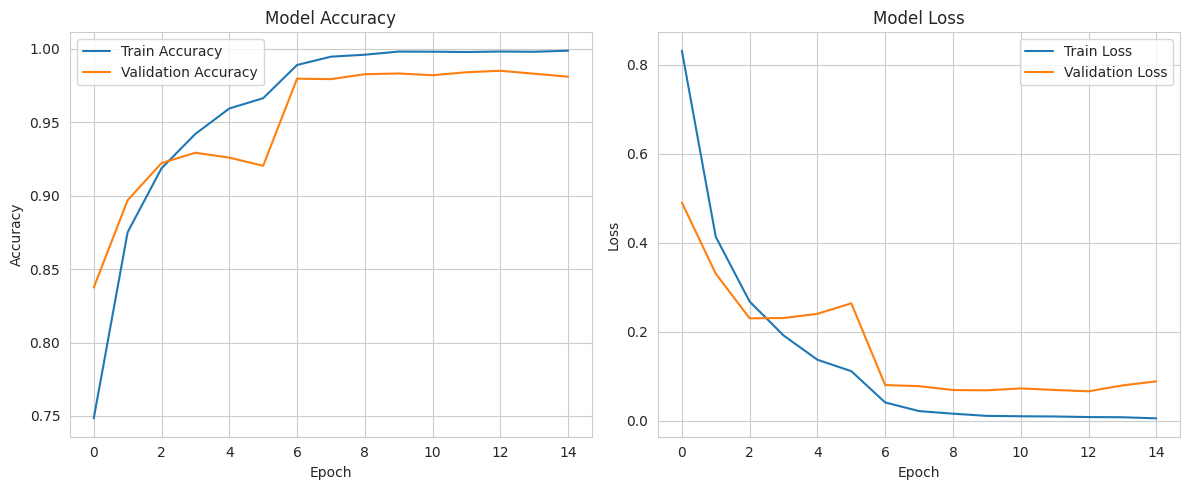

In [ ]:
# Plot Akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
train_loss, train_acc = model.evaluate(train_generator, verbose=1)
print(f"\n✅ Akurasi pada Training Set: {train_acc * 100:.2f}%")

747/747 ━━━━━━━━━━━━━━━━━━━━ 136s 182ms/step - accuracy: 0.9987 - loss: 0.0035

✅ Akurasi pada Training Set: 99.89%


In [ ]:
val_loss, val_acc = model.evaluate(validation_generator, verbose=1)
print(f"\n✅ Akurasi pada Validation Set: {val_acc * 100:.2f}%")

187/187 ━━━━━━━━━━━━━━━━━━━━ 34s 182ms/step - accuracy: 0.9905 - loss: 0.0461

✅ Akurasi pada Validation Set: 98.11%


In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"\n✅ Akurasi pada Test Set: {test_acc * 100:.2f}%")

3888/3888 ━━━━━━━━━━━━━━━━━━━━ 43s 10ms/step - accuracy: 0.9514 - loss: 0.2167

✅ Akurasi pada Test Set: 92.75%


In [ ]:
# Prediksi menggunakan model
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Ambil label asli dari generator
y_true = test_generator.classes

# Ambil label nama
labels = list(test_generator.class_indices.keys())

print("\n✅ Prediksi selesai. Siap untuk evaluasi.")

3888/3888 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step

✅ Prediksi selesai. Siap untuk evaluasi.


In [ ]:
# Classification Report
print("\n🔍 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))


🔍 Classification Report:

              precision    recall  f1-score   support

     battery       0.93      0.95      0.94       189
  biological       0.88      0.96      0.92       200
   cardboard       0.84      0.95      0.89       365
     clothes       0.99      0.98      0.99      1065
       glass       0.93      0.91      0.92       613
     medical       0.94      0.95      0.94        61
       metal       0.79      0.87      0.83       204
       paper       0.94      0.87      0.90       344
     plastic       0.92      0.82      0.87       452
       shoes       0.94      0.96      0.95       395

    accuracy                           0.93      3888
   macro avg       0.91      0.92      0.91      3888
weighted avg       0.93      0.93      0.93      3888



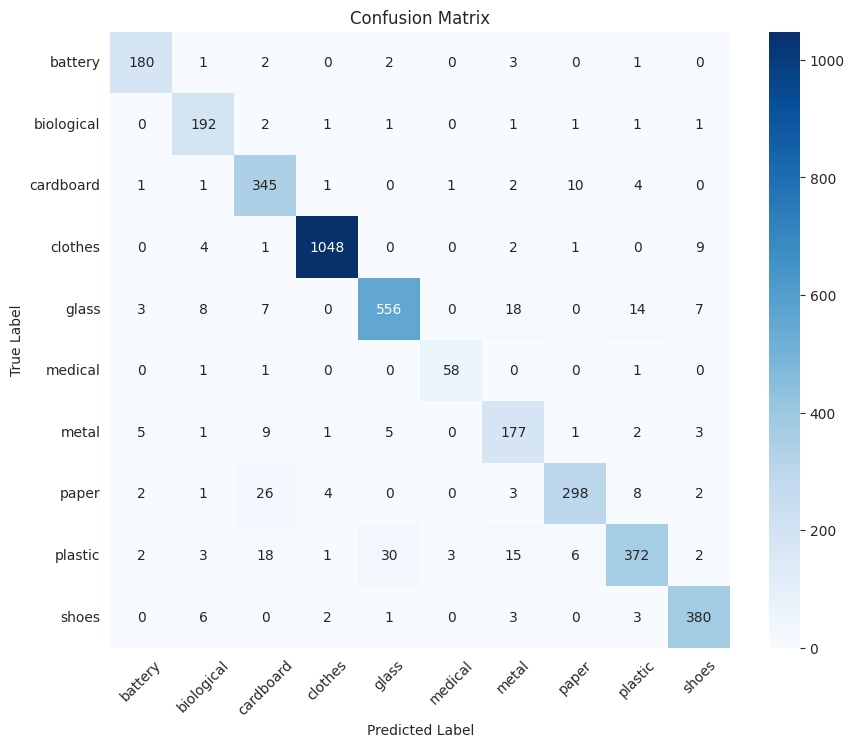

In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Konversi Model

Pada tahap ini dilakukan konversi model ke dalam format SavedModel untuk kebutuhan inferensi dan format TensorFlowJS untuk kebutuhan integrasi ke dalam web

In [ ]:
# Urutan labels yang digunakan pada pelatihan model
labels = test_generator.class_indices.keys()
labels

dict_keys(['battery', 'biological', 'cardboard', 'clothes', 'glass', 'medical', 'metal', 'paper', 'plastic', 'shoes'])

In [ ]:
# Download labels dalam format txt
with open('labels.txt', 'w') as f:
  for item in labels:
    f.write("%s\n" % item)

## SavedModel

In [ ]:
save_path = '/content/model_vgg16/'
tf.saved_model.save(model, save_path)

In [ ]:
# Download folder
from google.colab import files
files.download('/content/model_vgg16/saved_model.pb')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r variables.zip /content/model_vgg16/variables/
files.download('variables.zip')

  adding: content/model_vgg16/variables/ (stored 0%)
  adding: content/model_vgg16/variables/variables.index (deflated 71%)
  adding: content/model_vgg16/variables/variables.data-00000-of-00001 (deflated 14%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## TFJS

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model /content/model_vgg16 /content/modelvgg16_tfjs

2025-05-19 13:22:23.217265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747660943.439371   17763 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747660943.493734   17763 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-19 13:22:34.219210: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1747660954.219538   17763 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [ ]:
!zip -r tfjs_model_vgg16.zip /content/modelvgg16_tfjs/
files.download('tfjs_model_vgg16.zip')

  adding: content/modelvgg16_tfjs/ (stored 0%)
  adding: content/modelvgg16_tfjs/group1-shard1of27.bin (deflated 7%)
  adding: content/modelvgg16_tfjs/group1-shard16of27.bin (deflated 8%)
  adding: content/modelvgg16_tfjs/group1-shard22of27.bin (deflated 8%)
  adding: content/modelvgg16_tfjs/group1-shard12of27.bin (deflated 7%)
  adding: content/modelvgg16_tfjs/group1-shard20of27.bin (deflated 8%)
  adding: content/modelvgg16_tfjs/group1-shard5of27.bin (deflated 7%)
  adding: content/modelvgg16_tfjs/group1-shard19of27.bin (deflated 8%)
  adding: content/modelvgg16_tfjs/group1-shard21of27.bin (deflated 8%)
  adding: content/modelvgg16_tfjs/group1-shard15of27.bin (deflated 8%)
  adding: content/modelvgg16_tfjs/group1-shard2of27.bin (deflated 7%)
  adding: content/modelvgg16_tfjs/group1-shard10of27.bin (deflated 7%)
  adding: content/modelvgg16_tfjs/group1-shard7of27.bin (deflated 7%)
  adding: content/modelvgg16_tfjs/group1-shard9of27.bin (deflated 7%)
  adding: content/modelvgg16_tfjs/m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Inference/Testing


Pada tahap ini dilakukan inferensi untuk melihat hasil prediksi terhadap data testing yang belum pernah dilihat model

In [ ]:
# Data Testing
zip_file_path = 'data_test.zip'
extract_dir = 'data_test'
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

file_names = []
paths = []
labels = []

for root, _, files in os.walk(extract_dir):
    # Determine the label from the directory name (assuming one level of subdirectories for labels)
    label = os.path.basename(root)
    if root == extract_dir: # Skip the root directory itself if it doesn't represent a label
        continue

    for file in files:
        full_path = os.path.join(root, file)
        file_names.append(file)
        paths.append(full_path)
        labels.append(label)

df_test = pd.DataFrame({
    'file_name': file_names,
    'path': paths,
    'labels': labels
})

In [ ]:
df_test

file_name                                     path   labels
0     plastic_2349.jpg  data_test/test/plastic/plastic_2349.jpg  plastic
1        trash_520.jpg     data_test/test/plastic/trash_520.jpg  plastic
2     plastic_2723.jpg  data_test/test/plastic/plastic_2723.jpg  plastic
3      plastic_481.jpg   data_test/test/plastic/plastic_481.jpg  plastic
4      plastic_207.jpg   data_test/test/plastic/plastic_207.jpg  plastic
...                ...                                      ...      ...
3883      trash_61.jpg      data_test/test/medical/trash_61.jpg  medical
3884     trash_188.jpg     data_test/test/medical/trash_188.jpg  medical
3885     trash_804.jpg     data_test/test/medical/trash_804.jpg  medical
3886     trash_249.jpg     data_test/test/medical/trash_249.jpg  medical
3887     trash_604.jpg     data_test/test/medical/trash_604.jpg  medical

[3888 rows x 3 columns]

In [ ]:
print("\nValue counts for labels:")
print(df_test['labels'].value_counts())


Value counts for labels:
labels
clothes       1065
glass          613
plastic        452
shoes          395
cardboard      365
paper          344
metal          204
biological     200
battery        189
medical         61
Name: count, dtype: int64


In [ ]:
zip_file_path = 'saved_model.zip'
extract_dir = 'model_vgg'
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
# Mendefinisikan TFSMLayer
saved_model_path = "/content/model_vgg/content/saved_model"
tfsm_layer = TFSMLayer(saved_model_path, call_endpoint="serving_default")

# Format Keras Model
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)
outputs = tfsm_layer(inputs)
model = Model(inputs, outputs)


In [ ]:
# Path ke folder data test
test_path = "/content/data_test/test"
target_size = (224, 224)

# Fungsi preprocessing
def preprocess_image(path):
    img = tf.keras.preprocessing.image.load_img(path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    return tf.expand_dims(img_array, axis=0), img_array  # return both for display

# Sampel
df_sample = df_test.sample(n=10, random_state=0).copy()

# Hasil
predicted_labels = []
confidence_scores = []
image_arrays = []

# Loop untuk prediksi
for _, row in df_sample.iterrows():
    img_path = os.path.join(test_path, row['labels'], row['file_name'])
    img_batch, img_array = preprocess_image(img_path)
    preds = model.predict(img_batch, verbose=0)

    # Handle dictionary output (e.g., {'output_0': array([[...]]), ...})
    if isinstance(preds, dict):
        preds = list(preds.values())[0]

    preds = preds[0]  # ambil batch pertama (karena batch size = 1)
    pred_index = np.argmax(preds)

    predicted_labels.append(pred_index)
    confidence_scores.append(preds[pred_index])
    image_arrays.append(img_array)

# Tambahkan hasil ke DataFrame
df_sample['predicted_class'] = predicted_labels
df_sample['confidence'] = confidence_scores
df_sample['image_array'] = image_arrays

# Ambil urutan label
label_names = sorted(df_test['labels'].unique())
df_sample['predicted_label'] = [label_names[i] for i in df_sample['predicted_class']]

# Tampilkan hasil
print(df_sample[['file_name', 'labels', 'predicted_label', 'confidence']])


              file_name     labels predicted_label  confidence
534       glass_708.jpg      glass           glass    0.999840
2983  cardboard_533.jpg  cardboard       cardboard    0.998587
868      glass_3328.jpg      glass         battery    0.974889
3138   cardboard_13.jpg  cardboard           paper    0.990475
3779    battery_565.jpg    battery         battery    0.999998
3793    battery_804.jpg    battery         battery    0.999998
2657     paper_1625.jpg      paper           paper    0.999997
2039    clothes_798.jpg    clothes         clothes    0.999998
3589     shoes_1153.jpg      shoes           shoes    0.999920
2505     metal_1843.jpg      metal           metal    0.999689


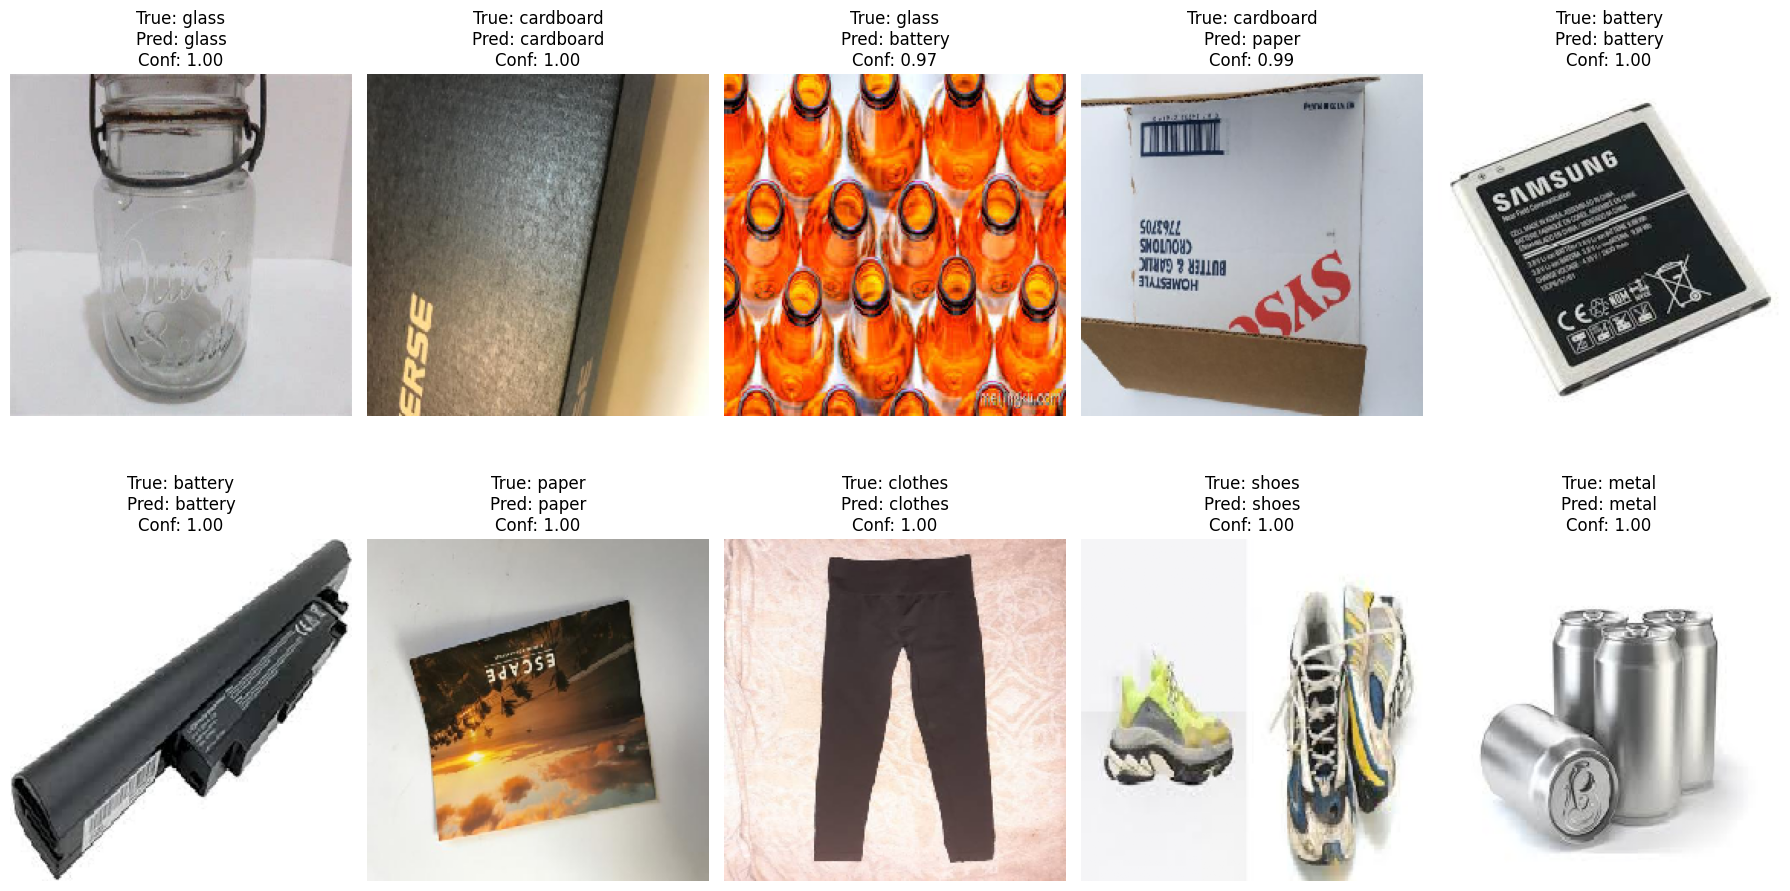

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))
for i, row in enumerate(df_sample.itertuples()):
    plt.subplot(2, 5, i + 1)
    plt.imshow(row.image_array.astype('float32'))
    plt.axis('off')
    plt.title(f"True: {row.labels}\nPred: {row.predicted_label}\nConf: {row.confidence:.2f}")
plt.tight_layout()
plt.show()
